## Sensitivity analysis

This notebook considers the sensitivity of leaf temperature to different input variables. Most of the inputs to energy balance models are derived from flux towers, which have some level of uncertainty. Towers in the [National Ecological Observatory Network](https://www.neonscience.org/) publish detailed information on uncertainty of these observations. We can use this to estimate how uncertainty propagates into the model output.

Prior to taking this course, I wrote a [Shiny application](http://ganzk.shinyapps.io/shiny_tealeaves) to approach this analysis interactively. This preliminary work indicated the following:
 - Leaf temperature is primarily determined by air temperature, so it is useful to instead focus on the leaf-air temperature difference.
 - Model output is sensitive to only a few variables and only under certain conditions.

For this analysis, we will consider sensitivity in two archetypical environments: a tropical ecosystem (warm and wet) and a temperate ecosystem (cool and dry).

## Setup

In [1]:
if occursin("notebooks", pwd())
    cd("..") 
end

println(pwd())

using Cropbox
using Unitful
using DataFrames
using Plots
using Gadfly

include("leaf_eb_still.jl")

G:\Other computers\My Laptop\UW\Classes\SEFS508\Project


WebIO._IJuliaInit()

LeafTemperature_Still

We use the parameterizations for a tropical broadleaf forest and a temperate needleleaf forest from the previous notebook.

In [2]:
@system LeafTemperatureTemperate(LeafTemperature_Still, LatentHeat, NeedleleafConductance, Air, Controller) begin
    d: characteristic_dimension => 0.01 ~ preserve(parameter, u"m")
    g0: intercept => 0 ~ preserve(parameter, u"mmol / m^2 / s")
    g1: slope => 2.35 ~ preserve(parameter, u"kPa^0.5")
    Ta: air_temperature => 290 ~ preserve(parameter, u"K")
    RH: relative_humidity => 0.3 ~ preserve(parameter)
end

@system LeafTemperatureTropical(LeafTemperature_Still, LatentHeat, BroadleafConductance, Air, Controller) begin 
    d: characteristic_dimension => 0.1 ~ preserve(parameter, u"m")
    g0: intercept => 0 ~ preserve(parameter, u"mmol / m^2 / s")
    g1: slope => 3.77 ~ preserve(parameter, u"kPa^0.5")
    Ta: air_temperature => 300 ~ preserve(parameter, u"K")
    RH: relative_humidity => 0.8 ~ preserve(parameter)
end

LeafTemperatureTropical

### Sensitivity of leaf spectral characteristics

We have to make certain assumptions about the spectral characteristics of leaves. These are assumed, so we don't have a reference uncertainty to go off of. Generally, leaf emissivity is close to 1 and shortwave absorptance is about 0.5. This segment considers the sensitivity of each property in the tropical and temperature cases.

In [3]:
xstep = :Leaf => :α_LW => 0.8:0.01:1.0
group = :Leaf => :α_SW => 0.4:0.04:0.6

:Leaf => (:α_SW => 0.4:0.04:0.6)

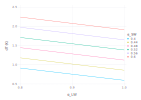

In [4]:
visualize(LeafTemperatureTropical, :α_LW, :dT; group, xstep, kind=:line, ylim=(0.5, 2.5), xlim=(0.8, 1.0))

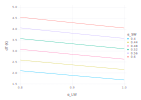

In [5]:
visualize(LeafTemperatureTemperate, :α_LW, :dT; group, xstep, kind=:line, ylim=(1.5, 5.0), xlim=(0.8, 1.0))

In the tropical case, uncertainty in longwave absorptance drives about 0.25 K variation in model output, while uncertainty in shortwave absorptance drives about 1.25 K variation in model output. In the temperate case this rises to about 1 K and 3 K, respectively. This indicates that the model is more sensitive to shortwave absorptance than longwave. This makes sense because generally more radiation reaches a plant as shortwave radiation (about 800 W/m$^2$) instead of longwave radiation (about 350 W/m$^2$).

### Sensitivity of leaf size

Another assumption we make is leaf size. Leaf size is used to calculate boundary layer conductance to heat transfer, which influences overall latent heat flux. Since total leaf conductance is the parallel sum of boundary layer and stomatal conductance, we can expect the sensitivity of leaf size to depend on stomatal conductance. Indeed, the model quantifies this with the decoupling coefficient ($\Omega$).

Since $g_s$ is a calculated parameter in the `UnifiedStomatalConductance` system, we have to define a dummy system that redefines that variable as a parameter.

In [6]:
@system StomatalConductanceDummy(LeafTemperatureTropical) begin
    gs: stomatal_conductance => 400 ~ preserve(parameter, u"mmol / m^2 / s")
end

xstep = :0 => :gs => 1:10:400
group = :0 => :d => [0.01, 0.05, 0.1, 0.5] # Conifer needle -- palm tree range

0 => (:d => [0.01, 0.05, 0.1, 0.5])

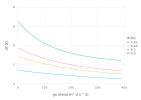

In [7]:
visualize(StomatalConductanceDummy, :gs, :dT; group, xstep, kind=:line, ylim=(0, 8), xlim=(0, 400))

As expected, larger leaf size results in larger boundary layer conductance. But, the difference is larger at low values of stomatal conductance. This is somewhat unintuitive. When stomatal conductance is high, total conductance is limited by the boundary layer conductance. So, raising leaf size should have a large impact on total conductance and drive a large change in leaf temperature. Instead, we see the opposite effect.

### Sensitivity of radiation type

Two kinds of radiation heat the leaf: longwave and shortwave. We have already learned that the model is more sensitive to shortwave absorptance than longwave absorptance because there is more energy in shortwave radiation. What about sensitivity to the type of radiation? To answer this question, we define a slightly more complex dummy system that lets us simultaneously drive longwave and shortwave radiation.

In [8]:
@system RadiationDummy(LeafTemperatureTemperate) begin
    LW_base: base_longwave => 200 ~ preserve(parameter, u"W / m^2")
    SW_base: base_shortwave => 600 ~ preserve(parameter, u"W / m^2")

    add_rad: added_radiation => 200 ~ preserve(parameter, u"W / m^2")
    k: radiation_partition => 0 ~ preserve(parameter)

    SW_in(SW_base, k, add_rad): shortwave_downwelling => begin
        SW_base + k * add_rad
    end ~ track(u"W / m^2")

    LW_in(LW_base, k, add_rad): longwave_downwelling => begin
        LW_base + (1 - k) * add_rad
    end ~ track(u"W / m^2")
end

RadiationDummy

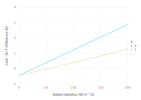

In [9]:
xstep = :0 => :add_rad => 0:1:200
group = :0 => :k => [0, 1]

# k = 1 means adding to shortwave
# k = 0 means adding to longwave
visualize(RadiationDummy, :add_rad, :dT; group, xstep, kind=:line, 
    ylim=(-1, 4), xlim=(0, 200), ylab="Leaf - Air T difference", xlab="Added radiation")

The above output indicates that the model is more sensitive to additions of longwave energy than shortwave energy. This makes sense since longwave absorptance is higher than shortwave absorptance.

### General sensitivity analysis

Let's now extend the above example to consider the sensitivity of many variable at once. We will build on top of the `LeafTemperatureTemperate` system to drive several parameters with another variable. Since all of these variables are on different scales, we will force them up or down by 20% and see how this affects $dT$.

In [10]:
function force_variable(var, var_k, k, f)
    if (k == var_k)
        return var * f
    else
        return var
    end
end

@system GeneralSensitivity(LeafTemperatureTemperate) begin
    k: param_selector => 0 ~ preserve(parameter)
    f: forcing => 1.0 ~ preserve(parameter)

    # Define base values for all the parameters
    LW_base: base_longwave => 300 ~ preserve(parameter, u"W / m^2")
    SW_base: base_shortwave => 800 ~ preserve(parameter, u"W / m^2")
    RH_base: base_rel_hum => 0.5 ~ preserve(parameter)
    gs_base: base_gs => 200 ~ preserve(parameter, u"mmol / m^2 / s")
     u_base: base_wind => 1 ~ preserve(parameter, u"m / s")
     A_base: base_photosynth => 20 ~ preserve(parameter, u"μmol / m^2 / s")
    Ca_base: base_co2 => 400 ~ preserve(parameter, u"μmol / mol")

    # Now set up how all of these are forced. 
    LW_in(LW_base, k, f): longwave_downwelling => begin
        force_variable(LW_base, 0, k, f)
    end ~ track(u"W / m^2")

    SW_in(SW_base, k, f): shortwave_downwelling => begin
        force_variable(SW_base, 1, k, f)
    end ~ track(u"W / m^2")

    RH(RH_base, k, f): relative_humidity => begin
        force_variable(RH_base, 2, k, f)
    end ~ track()

    gs(gs_base, k, f): stomatal_conductance => begin
        force_variable(gs_base, 3, k, f)
    end ~ track(u"mmol / m^2 / s")

    u(u_base, k, f): wind_speed => begin
        force_variable(u_base, 4, k, f)
    end ~ track(u"m / s")

    A(A_base, k, f): net_photosynthesis => begin
        force_variable(A_base, 5, k, f)
    end ~ track(u"μmol / m^2 / s")

    Ca(Ca_base, k, f): co2_conc => begin
        force_variable(Ca_base, 6, k, f)
    end ~ track(u"μmol / mol")
end

GeneralSensitivity

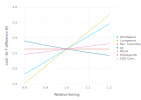

In [11]:
p = nothing
names = ["Shortwave", "Longwave", "Rel. humidity", "gs", "Wind", "Photosynth", "CO2 Conc."]

for k = 0:6 
    this_config = :0 => :k => k
    if k == 0
        p = visualize(
            GeneralSensitivity, :f, :dT; config=this_config, xstep=:0 => :f => 0.8:0.01:1.2,
            xlab="Relative forcing",
            ylab="Leaf - Air T difference",
            xlim = (0.78, 1.22),
            ylim = (1.5, 4),
            name = names[k+1],
            kind = :line
        )
    else
        visualize!(
            p,
            GeneralSensitivity, :f, :dT; 
            config=this_config, xstep=:0 => :f => 0.8:0.01:1.2,
            name=names[k+1],
            kind = :line
        )
    end
end

p